<img src="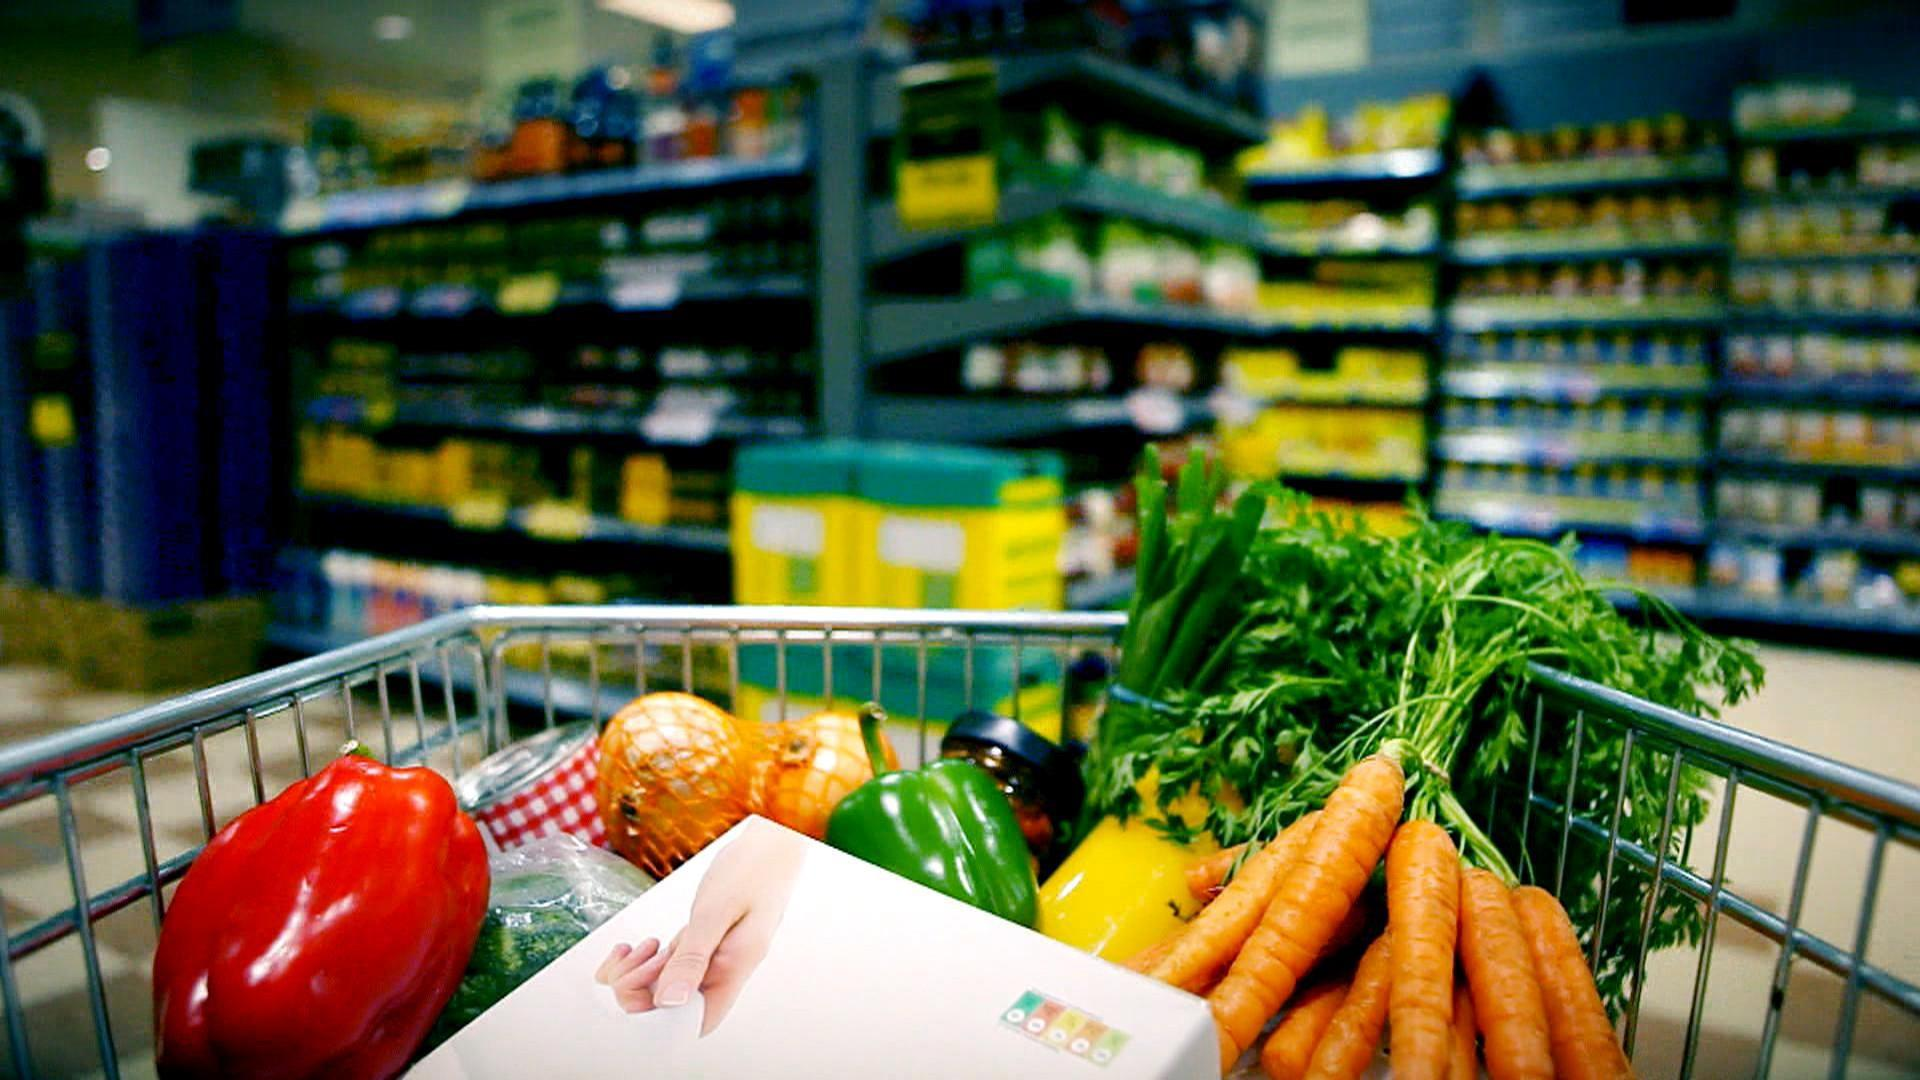
">

# Project: Forecasting Monthly Departmental Store Sales from a time series data using Neural Networks (LSTM and RNN), ARIMA and Facebook's prophet library

In this project we will be working with a Departmental Store Sales data set and it contains following features,

* Date                  : Sales month
* Sales                 : Cumlative sales for the month in Millions $


We will be forecasting monthly Departmental Store Sales from a time series data using Neural Networks (LSTM and RNN), ARIMA and Facebook's prophet library

In [1]:
import pandas as pd                                # to work with dataframe
import numpy as np                                 # to perform mathematical operations
import matplotlib.pyplot as plt                    # to visualisze
import cufflinks as cf                             # to create interactive visuals
import warnings
warnings.filterwarnings("ignore")
cf.go_offline() 
%matplotlib inline

In [130]:
data=pd.read_csv('Store_Sales.csv',index_col='Date',parse_dates=True) # load data and converting date column as index

In [131]:
data.head()                                                         # checking head of data set

,Sales
Date,
1992-01-01,10306
1992-02-01,11251
1992-03-01,12917
1992-04-01,13461
1992-05-01,14286


In [4]:
data.tail()                                                         # checking tail of data set to see last avilable date

,Sales
Date,
2016-06-01,12308
2016-07-01,11836
2016-08-01,12628
2016-09-01,11355
2016-10-01,11945


In [5]:
data.shape

(298, 1)

In [6]:
data['Sales'].iplot(kind='line',title='Departmental Store Sales Over the years', # Visualizing sales over the year
                    xTitle='Year',yTitle='Sales Quantity')

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose        # This is used to find out seasonal, trend, 
                                                               # residuals of the data

In [8]:
decompose = seasonal_decompose(data['Sales'])                 # here we are decomposing the sales data

In [9]:
decompose.trend.iplot(kind='line',title='Trend: Departmental Store Sales Over the years') # visualizing only the trend component

In [10]:
decompose.seasonal.iplot(kind='line',                   # visualizing only the seasonal component. It has yearly seasonality
                         title='Seasonal: Departmental Store Sales Over the years')

In [11]:
decompose.resid.iplot(kind='line',          # visualizing only the residual component
                      title='Residual: Departmental Store Sales Over the years')

### Part A: Long short-term memory (LSTM) and Recurrent Neural Network(RNN)

In [12]:
data.shape

(298, 1)

Lets build our model to predict last 12 month of sales. So train size will be 298-12 = 286, and test size will be 12

In [13]:
train = data.iloc[:286]
test = data.iloc[286:]

In [14]:
train.shape

(286, 1)

In [15]:
test.shape

(12, 1)

Machine learning and neural network algorithms works better when the features are in same scale

In [16]:
from sklearn.preprocessing import MinMaxScaler  # To normalize the data. Let's use minmax function to normalize it here
scaler = MinMaxScaler()

In [17]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.fit_transform(test)

Time Series Generator takes in a sequence of data-points gathered at equal intervals, along with time series parameters to produce batches for training/validation.

In [18]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [19]:
# define generator
n_input = 12 # We feed in 12 datapoints and predict the 13th data point
n_features = 1 # number of varibales. In this case, we have just one, sales column and so it will be 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1) # note: we are using 
                                                                    # scaled_train twice. its because we are taking the data 
                                                                    # from scaled_train and prediciting the data within 
                                                                    # scaled_train

In [20]:
generator[0]                                      # checking just the first batch.
                                                  # we used 12 data points and predicted the 13th data point, 0.0357336

(array([[[0.        ],
         [0.03935696],
         [0.10874183],
         [0.13139811],
         [0.16575736],
         [0.12694182],
         [0.11640498],
         [0.18645621],
         [0.12565074],
         [0.19386948],
         [0.32576736],
         [0.70434384]]]), array([[0.03573362]]))

In [21]:
generator[1]

(array([[[0.03935696],
         [0.10874183],
         [0.13139811],
         [0.16575736],
         [0.12694182],
         [0.11640498],
         [0.18645621],
         [0.12565074],
         [0.19386948],
         [0.32576736],
         [0.70434384],
         [0.03573362]]]), array([[0.04139769]]))

In [22]:
len(generator) # Basically len of generator is : len(train)-12

274

It took first 12 data points (x) in the train set and predicted the 13th element (y) in the train set for 1st batch and so on and hence the length is 274 not 286

In [23]:
x,y=generator[0]

In [24]:
x

array([[[0.        ],
        [0.03935696],
        [0.10874183],
        [0.13139811],
        [0.16575736],
        [0.12694182],
        [0.11640498],
        [0.18645621],
        [0.12565074],
        [0.19386948],
        [0.32576736],
        [0.70434384]]])

In [25]:
y

array([[0.03573362]])

In [27]:
# importing necessary packages for the model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# define model
model = Sequential()
model.add(LSTM(240, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 240)               232320    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 241       
Total params: 232,561
Trainable params: 232,561
Non-trainable params: 0
_________________________________________________________________


In [29]:
# fit model
model.fit_generator(generator,epochs=60)

W0914 09:27:19.543710 17460 deprecation.py:323] From C:\Users\selvam.periyasamy\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0914 09:27:20.076103 17460 deprecation_wrapper.py:119] From C:\Users\selvam.periyasamy\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0914 09:27:20.161490 17460 deprecation_wrapper.py:119] From C:\Users\selvam.periyasamy\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/60
274/274 [==============================] - 4s 15ms/step - loss: 0.0354
Epoch 2/60
274/274 [==============================] - 3s 11ms/step - loss: 0.0117
Epoch 3/60
274/274 [==============================] - 3s 12ms/step - loss: 0.0066
Epoch 4/60
274/274 [==============================] - 3s 11ms/step - loss: 0.0027
Epoch 5/60
274/274 [==============================] - 3s 11ms/step - loss: 0.0023
Epoch 6/60
274/274 [==============================] - 3s 11ms/step - loss: 0.0034
Epoch 7/60
274/274 [==============================] - 3s 11ms/step - loss: 0.0014
Epoch 8/60
274/274 [==============================] - 3s 11ms/step - loss: 0.0013
Epoch 9/60
274/274 [==============================] - 3s 12ms/step - loss: 0.0018
Epoch 10/60
274/274 [==============================] - 3s 11ms/step - loss: 0.0016
Epoch 11/60
274/274 [==============================] - 3s 12ms/step - loss: 0.0012
Epoch 12/60
274/274 [==============================] - 3s 11ms/step - loss: 0.0015
Epoch 13/60
2

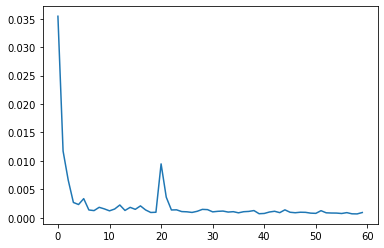

In [30]:
loss_per_epoch = model.history.history['loss']   # visual to find out the loss vs the epochs
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [31]:
first_eval_batch = scaled_train[-12:]

In [32]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get 1 data point prediction ahead ([0] is for picking just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store predicted valuess
    test_predictions.append(current_pred) 
    
    # update batch to include predicted value and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [33]:
RNN = scaler.inverse_transform(test_predictions)

In [34]:
test['RNN'] = RNN

In [35]:
test.iplot()

### Part B: AR and AUTO ARIMA Model

In [36]:
train = data.iloc[:286]
test = data.iloc[286:]

In [38]:
from statsmodels.tsa.ar_model import AR                  # Importing library for AR model 
from sklearn.metrics import mean_squared_error
model_ar = AR(train)
model_ar_fit = model_ar.fit()

C:\Users\selvam.periyasamy\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [39]:
AR = model_ar_fit.predict(start=286,end=297)            # Prediciting 12 points in to the future
AR

2015-11-01    16598.754784
2015-12-01    23616.769603
2016-01-01    10720.156608
2016-02-01    11181.871090
2016-03-01    13108.639143
2016-04-01    12286.278913
2016-05-01    13663.584864
2016-06-01    12543.940055
2016-07-01    12563.030721
2016-08-01    13662.400676
2016-09-01    12019.449628
2016-10-01    12920.651535
Freq: MS, dtype: float64

In [40]:
test['AR'] = AR

In [41]:
test.iplot()

ARIMA Models require data to be made stationary and define p,d,q order values to fine tune it. It is very time consuming. Fortunately, we have AUTO-ARIMA which can do all these steps by itself and predicts results with great accuracy 

In [42]:
from pmdarima import auto_arima

In [43]:
train = data.iloc[:286]
test = data.iloc[286:]

In [44]:
model = auto_arima(train, start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,  # since this is an seasonal data
                          d=None, D=1, trace=True,   # to see tried out different models
                          error_action='ignore',   # ignore if an order does not work
                          suppress_warnings=True,  # ignore convergence warnings
                          stepwise=True) 

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4208.769, BIC=4226.816, Fit time=1.811 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4285.963, BIC=4293.182, Fit time=0.038 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4247.799, BIC=4262.236, Fit time=1.288 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4214.297, BIC=4228.735, Fit time=2.024 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4210.387, BIC=4232.043, Fit time=4.427 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=4209.189, BIC=4223.627, Fit time=0.416 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=4210.754, BIC=4232.411, Fit time=5.130 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=4212.810, BIC=4238.076, Fit time=4.924 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4209.940, BIC=4231.597, Fit time=1.220 seconds
Fit ARIMA: order=(1, 1, 0) s

In [45]:
model.summary() # gives you the best model summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  286
Model:             SARIMAX(1, 1, 2)x(0, 1, 1, 12)   Log Likelihood               -2096.871
Date:                            Sat, 14 Sep 2019   AIC                           4205.742
Time:                                    09:33:58   BIC                           4227.399
Sample:                                         0   HQIC                          4214.436
                                            - 286                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -12.5447     13.343     -0.940      0.347     -38.696      13.607
ar.L1         -0.6875      0.124     -5.555      0.000      -0.930      -0.445
ma.L1          0.0899      0.140      0.644      0.519      -0.184       0.364
ma.L2         -0.5617      0.067     -8.428      0.000      -0.692      -0.431
ma.S.L12      -0.0856      0.031     -2.751      0.006      -0.147      -0.025
sigma2      2.061e+05   1.73e+04     11.907      0.000    1.72e+05     2.4e+05
===================================================================================
Ljung-Box (Q):                       99.40   Jarque-Bera (JB):               161.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.63
Prob(H) (two-sided):                  0.03   Kurtosis:                         6.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
ARIMA=model.predict(n_periods=12) # predicting 12 points in to the future

In [47]:
ARIMA

array([16467.06950037, 23590.41333349, 10446.82167806, 10963.26002097,
       12847.56130306, 12078.43342049, 13366.08666843, 12249.37536614,
       12201.77691114, 13326.46206194, 11656.06786694, 12571.93007356])

In [48]:
test['ARIMA'] = ARIMA

In [49]:
test.iplot()

### Part C: Facebook's Prophet Library

In [50]:
from fbprophet import Prophet

In [135]:
fb=data.copy()

In [136]:
fb['ds'] = fb.index

In [137]:
fb=fb.reset_index()

In [138]:
del fb['Date']

In [139]:
fb.columns = ['y','ds'] # Prophet library requires columns to be named like this

In [140]:
fb.head()

,y,ds
0,10306,1992-01-01
1,11251,1992-02-01
2,12917,1992-03-01
3,13461,1992-04-01
4,14286,1992-05-01


In [141]:
train = fb.iloc[:286]
test = fb.iloc[286:]

In [142]:
model = Prophet()
model.fit(train)
future = model.make_future_dataframe(periods=12,freq='MS')
additive = model.predict(future)

In [143]:
additive.tail(12)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
286,2015-11-01,13519.635052,15960.195298,17528.119905,13519.635052,13519.635052,3187.375343,3187.375343,3187.375343,3187.375343,3187.375343,3187.375343,0.0,0.0,0.0,16707.010395
287,2015-12-01,13488.817676,25427.938999,26875.804411,13488.817676,13488.817676,12623.537891,12623.537891,12623.537891,12623.537891,12623.537891,12623.537891,0.0,0.0,0.0,26112.355567
288,2016-01-01,13456.973055,8496.459500,10048.565933,13456.463130,13457.064399,-4153.844656,-4153.844656,-4153.844656,-4153.844656,-4153.844656,-4153.844656,0.0,0.0,0.0,9303.128399
289,2016-02-01,13425.128434,9493.141193,11047.523240,13422.530534,13427.493775,-3159.032145,-3159.032145,-3159.032145,-3159.032145,-3159.032145,-3159.032145,0.0,0.0,0.0,10266.096289
290,2016-03-01,13395.338304,11327.951002,12846.356139,13389.765740,13401.353602,-1329.138529,-1329.138529,-1329.138529,-1329.138529,-1329.138529,-1329.138529,0.0,0.0,0.0,12066.199775
291,2016-04-01,13363.493683,11197.842264,12746.964868,13354.437782,13373.979442,-1369.733455,-1369.733455,-1369.733455,-1369.733455,-1369.733455,-1369.733455,0.0,0.0,0.0,11993.760228
292,2016-05-01,13332.676307,12207.203742,13727.794588,13317.883444,13348.663525,-354.862437,-354.862437,-354.862437,-354.862437,-354.862437,-354.862437,0.0,0.0,0.0,12977.813870
293,2016-06-01,13300.831686,11427.850015,12939.534931,13280.079745,13322.171048,-1123.613116,-1123.613116,-1123.613116,-1123.613116,-1123.613116,-1123.613116,0.0,0.0,0.0,12177.218570
294,2016-07-01,13270.014310,10838.011527,12404.302293,13243.678795,13296.086702,-1675.937631,-1675.937631,-1675.937631,-1675.937631,-1675.937631,-1675.937631,0.0,0.0,0.0,11594.076679
295,2016-08-01,13238.169689,12277.475959,13832.960001,13204.180553,13268.977786,-195.335512,-195.335512,-195.335512,-195.335512,-195.335512,-195.335512,0.0,0.0,0.0,13042.834177


In [144]:
additive[['ds','yhat']].tail(12)

,ds,yhat
286,2015-11-01,16707.010395
287,2015-12-01,26112.355567
288,2016-01-01,9303.128399
289,2016-02-01,10266.096289
290,2016-03-01,12066.199775
291,2016-04-01,11993.760228
292,2016-05-01,12977.813870
293,2016-06-01,12177.218570
294,2016-07-01,11594.076679
295,2016-08-01,13042.834177


In [145]:
FB_Additive=pd.merge(test, additive[['ds','yhat']].tail(12), how='left', on='ds')

In [146]:
FB_Additive=FB_Additive.set_index('ds')

In [147]:
FB_Additive.iplot()

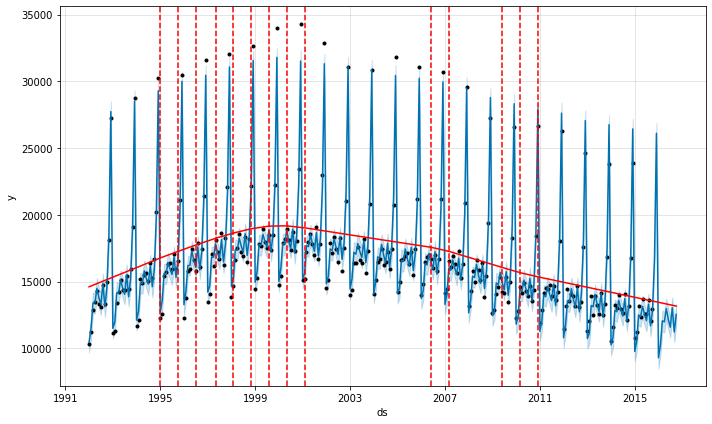

In [148]:
from fbprophet.plot import add_changepoints_to_plot  # this is to visualize changing trend points
fig = model.plot(additive)
a = add_changepoints_to_plot(fig.gca(), model, additive)

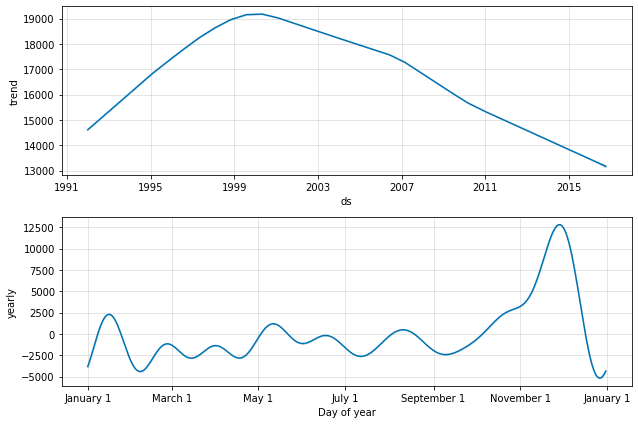

In [149]:
fig = model.plot_components(additive)

This library also allows to set seasonality mode as muliplicative as our data is like that. Lets build the model with multiplicative option

In [150]:
model = Prophet(seasonality_mode='multiplicative')
model.fit(train)
multiplicative = model.predict(future)

In [151]:
multiplicative.tail(12)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
286,2015-11-01,13514.303595,15544.977287,16480.914269,13514.303595,13514.303595,0.186095,0.186095,0.186095,0.186095,0.186095,0.186095,0.0,0.0,0.0,16029.253685
287,2015-12-01,13484.619346,22966.130111,23912.032219,13484.619346,13484.619346,0.736818,0.736818,0.736818,0.736818,0.736818,0.736818,0.0,0.0,0.0,23420.324701
288,2016-01-01,13453.945623,9710.247559,10661.121792,13452.617393,13455.612575,-0.243225,-0.243225,-0.243225,-0.243225,-0.243225,-0.243225,0.0,0.0,0.0,10181.615315
289,2016-02-01,13423.271900,10401.023749,11405.555561,13417.583889,13430.258959,-0.186341,-0.186341,-0.186341,-0.186341,-0.186341,-0.186341,0.0,0.0,0.0,10921.968060
290,2016-03-01,13394.577127,11805.269089,12820.359178,13381.820992,13411.099678,-0.080388,-0.080388,-0.080388,-0.080388,-0.080388,-0.080388,0.0,0.0,0.0,12317.819248
291,2016-04-01,13363.903404,11789.057674,12807.345065,13343.616889,13388.190259,-0.080322,-0.080322,-0.080322,-0.080322,-0.080322,-0.080322,0.0,0.0,0.0,12290.493981
292,2016-05-01,13334.219156,12585.145169,13557.144454,13306.808875,13367.228107,-0.020653,-0.020653,-0.020653,-0.020653,-0.020653,-0.020653,0.0,0.0,0.0,13058.826980
293,2016-06-01,13303.545433,11937.293839,12916.295744,13266.582920,13345.278557,-0.065869,-0.065869,-0.065869,-0.065869,-0.065869,-0.065869,0.0,0.0,0.0,12427.258536
294,2016-07-01,13273.861184,11439.960889,12452.226123,13227.962492,13325.199883,-0.099492,-0.099492,-0.099492,-0.099492,-0.099492,-0.099492,0.0,0.0,0.0,11953.219408
295,2016-08-01,13243.187461,12603.973745,13582.464534,13183.336750,13308.305139,-0.013235,-0.013235,-0.013235,-0.013235,-0.013235,-0.013235,0.0,0.0,0.0,13067.911659


In [152]:
FB_Multiplicative=pd.merge(test, multiplicative[['ds','yhat']].tail(12), how='left', on='ds')

In [153]:
FB_Multiplicative=FB_Multiplicative.set_index('ds')

In [154]:
FB_Multiplicative.iplot()

### Combining all the results

In [164]:
test = data.iloc[286:]

In [165]:
test['RNN'] = RNN
test['AR']=AR
test['ARIMA'] = ARIMA
test['FB_Additive']=FB_Additive['yhat']
test['FB_Multiplicative']=FB_Multiplicative['yhat']

In [166]:
test

,Sales,RNN,AR,ARIMA,FB_Additive,FB_Multiplicative
Date,,,,,,
2015-11-01,16301,13669.301761,16598.754784,16467.069500,16707.010395,16029.253685
2015-12-01,23425,17894.731200,23616.769603,23590.413333,26112.355567,23420.324701
2016-01-01,10221,10667.072355,10720.156608,10446.821678,9303.128399,10181.615315
2016-02-01,11208,11081.964660,11181.871090,10963.260021,10266.096289,10921.968060
2016-03-01,12648,11778.265904,13108.639143,12847.561303,12066.199775,12317.819248
2016-04-01,11925,11679.753464,12286.278913,12078.433420,11993.760228,12290.493981
2016-05-01,12536,11984.579192,13663.584864,13366.086668,12977.813870,13058.826980
2016-06-01,12308,11656.178092,12543.940055,12249.375366,12177.218570,12427.258536
2016-07-01,11836,11627.219504,12563.030721,12201.776911,11594.076679,11953.219408


In [167]:
test.iplot()

In [171]:
from sklearn import metrics
print("Root Mean Square Error-RNN:",np.sqrt(metrics.mean_squared_error(test['Sales'], test['RNN'])))
print("Root Mean Square Error-AR:",np.sqrt(metrics.mean_squared_error(test['Sales'], test['AR'])))
print("Root Mean Square Error-ARIMA:",np.sqrt(metrics.mean_squared_error(test['Sales'], test['ARIMA'])))
print("Root Mean Square Error-FB_Additive:",np.sqrt(metrics.mean_squared_error(test['Sales'], test['FB_Additive'])))
print("Root Mean Square Error-FB_Multiplicative:",np.sqrt(metrics.mean_squared_error(test['Sales'], test['FB_Multiplicative'])))

Root Mean Square Error-RNN: 1822.7924319810697
Root Mean Square Error-AR: 647.8842100282654
Root Mean Square Error-ARIMA: 410.99535366369616
Root Mean Square Error-FB_Additive: 925.1542273762076
Root Mean Square Error-FB_Multiplicative: 349.57348041183195


From the above chart, it is very clear that FB_Multiplicative model is more suitable for this data set